In [1]:
import json

import itertools
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set(style="whitegrid")

import rental_utils
from rental_utils import *; reload(rental_utils)

<module 'rental_utils' from 'rental_utils.pyc'>

In [2]:
train = pd.read_json('Data/train.json')
test = pd.read_json('Data/test.json')

In [3]:
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [4]:
feature_list = [[w.lower() for w in line] for line in train['features'].values]
totals = Counter(i for i in list(itertools.chain.from_iterable(feature_list)))

n_features = 10
print(totals.most_common(n_features))
features  = [x[0] for x in totals.most_common(n_features)]
feature_names = [x.replace(' ', '_') for x in features]

[(u'elevator', 26273), (u'hardwood floors', 23558), (u'cats allowed', 23540), (u'dogs allowed', 22035), (u'doorman', 20967), (u'dishwasher', 20806), (u'laundry in building', 18944), (u'no fee', 18079), (u'fitness center', 13257), (u'laundry in unit', 9435)]


In [5]:
train = add_features(train, features, feature_names)
test = add_features(test, features, feature_names)

In [6]:
independent = ['bathrooms', 'bedrooms', 'price'] + feature_names

In [7]:
interest_averages = train[independent+['interest_level']].groupby('interest_level').aggregate(np.mean)
interest_averages['interest_level'] = interest_averages.index
# print(interest_averages)

interest_melted = pd.melt(interest_averages, id_vars=['interest_level'], value_vars=independent)

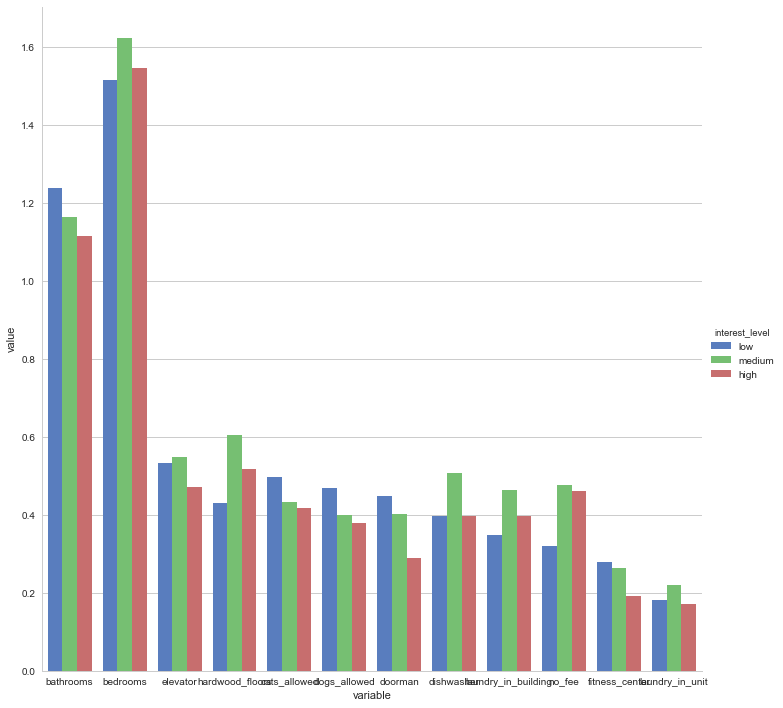

In [8]:
sns.factorplot(x="variable", y="value", hue="interest_level", 
               data=interest_melted.loc[interest_melted['variable']!='price'],
               size=10, kind="bar", palette="muted", hue_order=['low', 'medium', 'high'])

In [9]:
model = RandomForestClassifier()
model.fit(train[independent], train['interest_level'])
preds = model.predict(train[independent])
probs = model.predict_proba(train[independent])

In [10]:
print(train['interest_level'].values[:10])
print(preds[:10])

[u'medium' u'low' u'high' u'low' u'low' u'medium' u'low' u'low' u'medium'
 u'low']
[u'medium' u'low' u'low' u'low' u'low' u'medium' u'low' u'low' u'medium'
 u'low']


In [11]:
ct = pd.crosstab(preds, train['interest_level'].values, margins=False)
print(ct)

print('')
ct_perc = ct.apply(lambda x: x/sum(x), axis=1)
print(ct_perc)

print('')
accuracy = float(np.sum(preds==train['interest_level'].values))/len(preds)
print('Total Accuracy: ' + str(accuracy))

print('')
high_accuracy = ct_perc.iloc[0,0]
print('High Accuracy: ' + str(high_accuracy))
med_accuracy = ct_perc.iloc[1,1]
print('Medium Accuracy: ' + str(med_accuracy))
low_accuracy = ct_perc.iloc[2,2]
print('Low Accuracy: ' + str(low_accuracy))


col_0   high    low  medium
row_0                      
high    2301    280     390
low      906  32555    3537
medium   632   1449    7302

col_0       high       low    medium
row_0                               
high    0.774487  0.094244  0.131269
low     0.024488  0.879912  0.095600
medium  0.067356  0.154428  0.778216

Total Accuracy: 0.854230831577

High Accuracy: 0.774486704813
Medium Accuracy: 0.879912427699
Low Accuracy: 0.778215922413


In [12]:
submission = test[['listing_id']]
probs = model.predict_proba(test[independent])
submission = pd.concat([submission.reset_index(drop=True), pd.DataFrame(probs, columns=model.classes_)], axis=1)
submission = submission[['listing_id', 'high', 'medium', 'low']]

submission.loc[submission['high'] > high_accuracy, 'high'] = high_accuracy
submission.loc[submission['high'] < 1 - high_accuracy, 'high'] = 1 - high_accuracy
submission.loc[submission['medium'] > med_accuracy, 'medium'] = med_accuracy
submission.loc[submission['medium'] < 1 - med_accuracy, 'medium'] = 1 - med_accuracy
submission.loc[submission['low'] > low_accuracy, 'low'] = low_accuracy
submission.loc[submission['low'] < 1 - low_accuracy, 'low'] = 1 - low_accuracy

print(submission.head())
submission.to_csv('Submissions/submission3.csv', index=False)

   listing_id      high    medium       low
0     7142618  0.225513  0.800000  0.221784
1     7210040  0.225513  0.146344  0.768645
2     7103890  0.225513  0.120088  0.778216
3     7143442  0.225513  0.120088  0.778216
4     6860601  0.225513  0.120088  0.778216
